In [1]:
from utils.all import *

In [2]:
new_data = load_data('../annotated', batch_num=[1, 2, 3, 4], preprocess=True)

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json']

Found users: {'anton', 'vishnesh', 'kelly', 'vinayak', 'ayush', 'rachel'}

rachel - Batch 4, HIT 5 (ID 124) has 1 split edits but 0 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 4, HIT 15 (ID 134) has 1 split edits but 0 annotations. Likely a missing annotation. Skipping edit type...
When processing sentence: rachel - Batch 4, HIT 5 (ID 124). Caught error on: Could not process edit: {'type': 'deletion', 'id': 5, 'original_span': [(95, 98)], 'simplified_span': None, 'annotation': None}. Skipping...


In [3]:
old_data = load_data('../annotated', batch_num=[5, 6], preprocess=True)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'anton', 'vishnesh', 'kelly', 'vinayak', 'ayush', 'rachel'}

anton - Batch 5, HIT 38 (ID 23) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 27) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 39) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 39) has 4 insertion edits but 3 annotations. Likely a missing annotation.

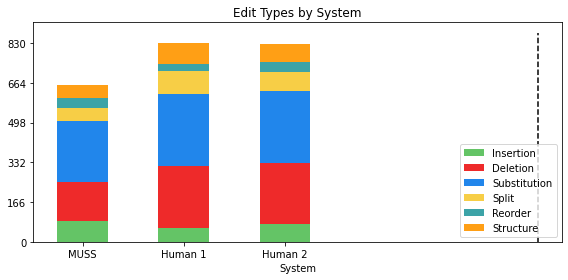

In [4]:
edit_type_by_system(old_data, flipped=True)

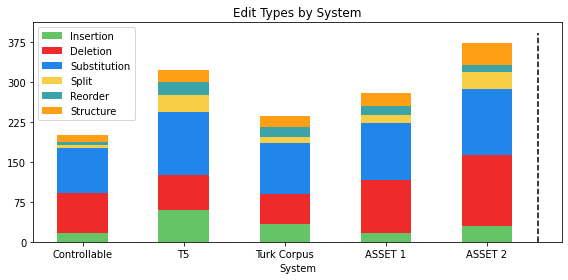

In [5]:
edit_type_by_system(new_data, flipped=True)

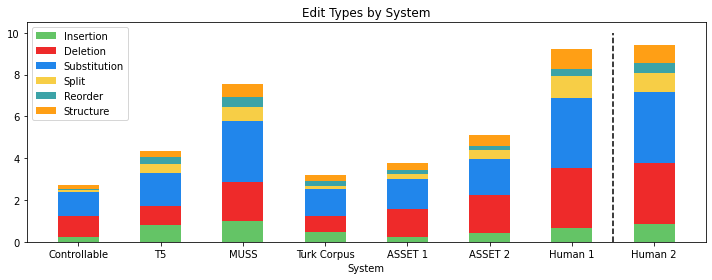

In [6]:
edit_type_by_system(new_data + old_data, flipped=True, normalized=True, all_datasets=True)

In [7]:
all_data = load_data('../annotated', preprocess=True)

Loading files: ['../annotated/batch_10_anton.json', '../annotated/batch_10_ayush.json', '../annotated/batch_10_kelly.json', '../annotated/batch_10_rachel.json', '../annotated/batch_10_vinayak.json', '../annotated/batch_10_vishnesh.json', '../annotated/batch_11_anton.json', '../annotated/batch_11_kelly.json', '../annotated/batch_11_rachel.json', '../annotated/batch_11_vinayak.json', '../annotated/batch_11_vishnesh.json', '../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json', '../annotated/batch_3_anton.json', '../annotated/batch_3_ayush.json', '../annotated/batch_3_kelly.json', '../annotated/batch_4_rachel.json', '../annotated/batch_4_vinayak.json', '../annotated/batch_4_vishnesh.json', '../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '.

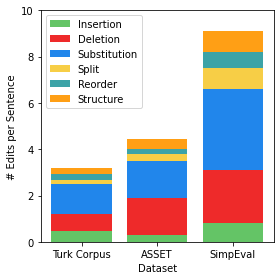

In [8]:
edit_type_by_system(all_data, humans=True, normalized=True)

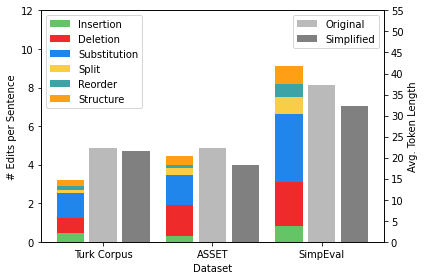

In [9]:
def edit_type_by_system(data, normalized=False):
    humans = ['Human', 'asset', 'turk_corpus']
    data = [sent for sent in copy.deepcopy(data) if any([human in sent['system'] for human in humans])]
    for sent_id in range(len(data)):
        sys_name = data[sent_id]['system']
        if 'Human' in sys_name:
            data[sent_id]['system'] = 'aggregated/simpeval'
        elif 'asset' in sys_name:
            data[sent_id]['system'] = 'aggregated/asset'
        elif 'turk_corpus' in sys_name:
            data[sent_id]['system'] = 'aggregated/turk'

    size = (6, 4)
    width = 0.25

    token_length = {}
    for type_ in ['original', 'simplified']:
        token_length[type_] = {}
        for sys in set([s['system'] for s in data]):
            sents = [sent for sent in data if sent['system'] == sys]
            token_length[type_][sys] = avg([len(sent[type_].split(' ')) for sent in sents])


    # Create sums of different dimensions
    sum_edit_types = {system: sum_edits(data, system=system, normalized=normalized) for system in systems}
    system_labels = [x for x in all_system_labels if x in set([sent['system'] for sent in data])]

    fig, ax = plt.subplots(figsize=size)
    bottom = [0 for x in range(len(system_labels))]
    system_names = [system_name_mapping[label] for label in system_labels]
    x = np.arange(len(system_names))
    for edit_type in edit_type_labels:
        val = [sum_edit_types[label][edit_type] for label in system_labels]
        ax.bar(x, val, width, bottom=bottom, label=edit_type.capitalize(), color=color_mapping[edit_type])
        bottom = [bottom[i] + val[i] for i in range(len(val))]

    ax2 = ax.twinx()
    val = [token_length['original'][label] for label in system_labels]
    ax2.bar(x+width+0.05, val, width, label='Original', color='#bababa') # 808080
    ax2.set_ylabel('Avg. Token Length')
    ax2.set_yticks([i*5 for i in range(12)])

    val = [token_length['simplified'][label] for label in system_labels]
    ax2.bar(x+2*width+0.05*2, val, width, label='Simplified', color='#808080') # 808080
    ax2.set_ylabel('Avg. Token Length')
    ax2.set_yticks([i*5 for i in range(12)])

    # ax.set_xticks(system_names)
    ax.set_xticks(x+width+0.05)
    ax.set_xticklabels(system_names)

    ax.set_xlabel('System')
    ax.set_title('Edit Types by System')
    ax.set_yticks([i*round(max(bottom)/5) for i in range(7)])

    ax.set_title('')
    ax.set_ylabel('# Edits per Sentence')
    ax.set_xlabel('Dataset')

    ax.legend()
    ax2.legend(loc='upper right')

    out_filename = "img/edit-type-human-written.pdf"
    plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)

    plt.show()

edit_type_by_system(all_data, normalized=True)